# CHT Forum Analysis

This notebook does some high level analysis on [CHT Forum](https://forum.communityhealthtoolkit.org/) engagements. It mainly can be divided into two parts.

1. **User analysis:** For the User analysis, we look into activity of users for example, how many topics were created? how many posts were replied? Number of signups compared with number of contributions.
2. **Content analysis:** For the Content analysis, we look into different categories in the CHT Forum along with subcategories. The questions arises example, are all categories and subcategories active in same way? Which one is popular? Is there any inactivity? Is there any confusions? duplicates? Overlaps? 

In [1]:
import urllib.request
import bs4 as bs
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

Settings for plotting images

In [2]:
sns.set_style('darkgrid')
sns.set(font_scale=1.25)
palette = sns.color_palette('Blues_r', 15)
palette2 = {'Medic':'mediumturquoise', 'Non-Medic':'dodgerblue'}
sns.set_theme(rc={'figure.figsize':(11,5)})

Next read the content from [CHT forum page](https://forum.communityhealthtoolkit.org/u?order=post_count&period=yearly), and save it in txt file and then read for analysing users.

- First for the analysis, we would like to have it as dataframe. So, some cleaning is done using BeautifulSoup and converted to pandas dataframe.
- Next, convert it to dataframe and rename columns as it is in the webpage.
**Note:** the number of columns may vary on criteria of time you select for e.g. 'Time Read' column only appears when you select 'all time' 

In [3]:
def convert_html_to_dataframe(html_filename, all_time=False):

    with open(html_filename, 'r') as file:
        html_content = file.read()
    
    soup = bs.BeautifulSoup(html_content)
    
    table = soup.find('div', attrs={'class':'directory-table'})
    table_body = table.find('div', attrs={'directory-table__body'})
    
    table_rows = table.find_all('div', attrs={'directory-table__row ember-view'})
    
    res = []
    for tr in table_rows:
        td_name = tr.find('div', attrs={'user-detail'}).find('div', attrs={'name-line'}).find('span', attrs={'name'})
        td_username = tr.find('div', attrs={'user-detail'}).find('div', attrs={'name-line'}).find('span', attrs={'username'})
    
        name_row = td_name.text.strip()
        username_row = td_username.text.strip()
        row = [name_row, username_row]
        all_col = tr.find_all('span', attrs={'directory-table__value'})
        for col in all_col:
            row.append(col.text.strip())
        res.append(row)

    df = pd.DataFrame(res)
    if all_time:
        df.columns = ['Name','Username', 'Topics created', 'Replies posted', 'Days Visited', 'Solutions', 'Time Read']
    else:
        df.columns = ['Name','Username', 'Topics created', 'Replies posted', 'Days Visited', 'Solutions']

    return df

Read to dataframe and confirm it is similar to what you see in the webpage.

In [4]:
df = convert_html_to_dataframe('html/html_content_all_time.txt', all_time=True)
df.head(3)

,Name,Username,Topics created,Replies posted,Days Visited,Solutions,Time Read
0,Diana Barsan,diana,18,759,550,83,3d
1,,mrjones,32,349,615,31,3d
2,Josh Kuestersteffen,jkuester,19,348,597,48,3d


# Finding Inactive Users

Inactive users are the ones who:
1. Do not create any topics
2. Have not posted any replies in that time period. 

In [5]:
def get_inactive_users(df, time_frame_txt=None):
    
    inactive_users = df[(df['Topics created']=='0')&(df['Replies posted']=='0')]

    print('-> There are {} users ({}).'.format(len(df), time_frame_txt))
    print('-> There are {} inactive users ({}).'.format(len(inactive_users), time_frame_txt))
    print('-> {} % users in CHT Forum has been inactive as of June 2024'.format(round((len(inactive_users)/len(df))*100),2))

    return inactive_users

First lets look into **inactive users in CHT Forum from all time** results

In [6]:
inactive_user_df = get_inactive_users(df, 'all time')

-> There are 733 users (all time).
-> There are 386 inactive users (all time).
-> 53 % users in CHT Forum has been inactive as of June 2024


Instead of all time we can focus on yearly and plan accordingly on how to strengthen CHT community in the forum.
So, looking into a year round i.e. June 2023 to June 2024 (June 7)

In [7]:
yearly_df = convert_html_to_dataframe('html/html_content.txt', all_time=False)

In [8]:
yearly_inactive_user_df = get_inactive_users(yearly_df, 'June 2023 to June 2024')

-> There are 733 users (June 2023 to June 2024).
-> There are 616 inactive users (June 2023 to June 2024).
-> 84 % users in CHT Forum has been inactive as of June 2024


# Yearly Active Users

From results above, we know **616 inactive users who have neither created any topic or posted any replies**. 
Now, let's look at active users which organizations they are from specifically comparing Medic vs Non-Medic and their frequency of engagements.

For this you nee to have existing file with username and organizations and then you can merge with active users dataframe and run analysis.

In [9]:
yearly_active_users = yearly_df[(yearly_df['Topics created']!='0')|(yearly_df['Replies posted']!='0')]

In [10]:
user_org_df = pd.read_csv('user_org.csv')

In [11]:
def plotting_org_compare(dataframe, focused_info, x_label, y_label, hue=None, title=''):
    dataframe[focused_info] = pd.to_numeric(dataframe[focused_info])
    if hue:
        ax = sns.countplot(data=dataframe, y=focused_info, order = sorted(dataframe[focused_info].value_counts().index), linewidth=0.75, edgecolor="k", hue='organization', palette=palette2)
        sns.move_legend(
            ax, "lower center",
            bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False
        )
        x_val = max(dataframe.groupby('organization')[focused_info].value_counts())+1
    else: 
        ax = sns.countplot(data=dataframe, y=focused_info, order = sorted(dataframe[focused_info].value_counts().index), linewidth=0.75, edgecolor="k")
        x_val = max(dataframe[focused_info].value_counts())
        
    plt.xticks([i for i in range(x_val+1)])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.figtext(0.5, 1.05, title, wrap=True, horizontalalignment='center', fontsize=15)
    plt.show()

In [12]:
merged_user_html_df = yearly_active_users.merge(user_org_df, how='left', left_on='Username', right_on='Username')
merged_user_html_df.drop(columns=['Name_x', 'Unnamed: 0'], inplace=True)
merged_user_html_df.rename(columns={'Name_y':'Name'}, inplace=True)

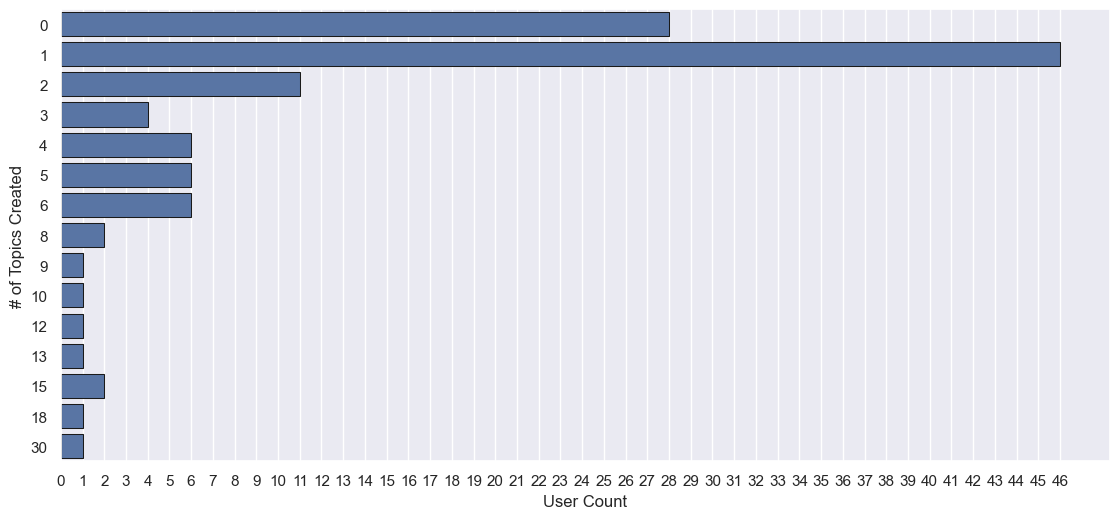

In [13]:
plotting_org_compare(merged_user_html_df, 'Topics created', 'User Count', '# of Topics Created')

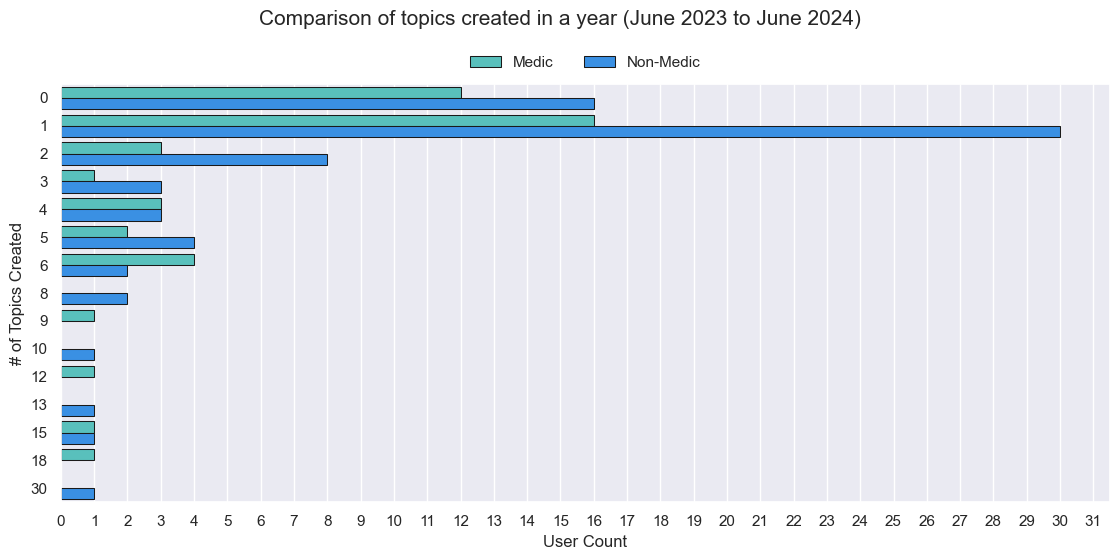

In [14]:
plotting_org_compare(merged_user_html_df, 'Topics created', 'User Count', '# of Topics Created', hue='organization', title='Comparison of topics created in a year (June 2023 to June 2024)')

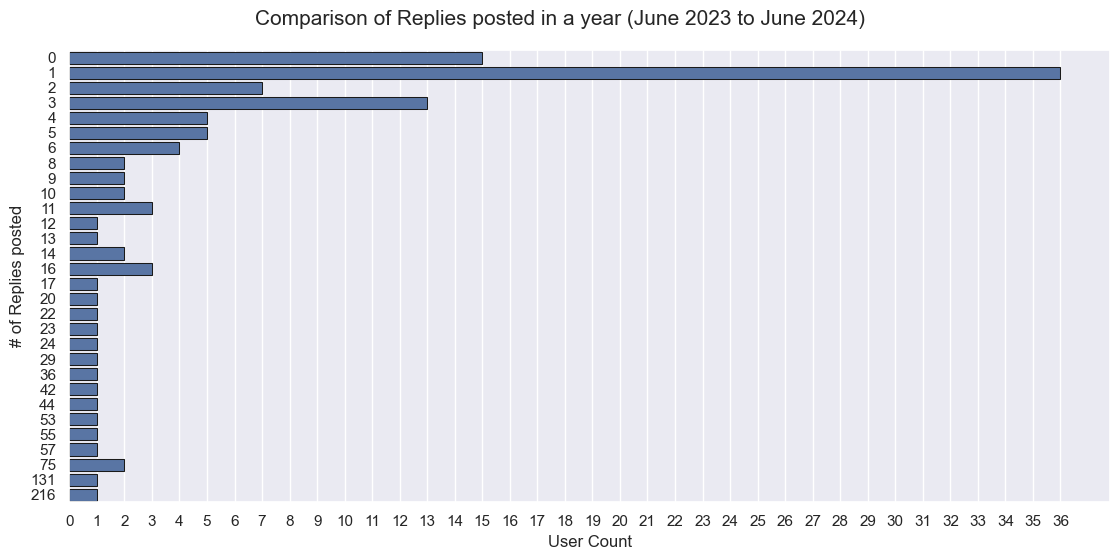

In [15]:
plotting_org_compare(merged_user_html_df, 'Replies posted', 'User Count', '# of Replies posted', title='Comparison of Replies posted in a year (June 2023 to June 2024)')

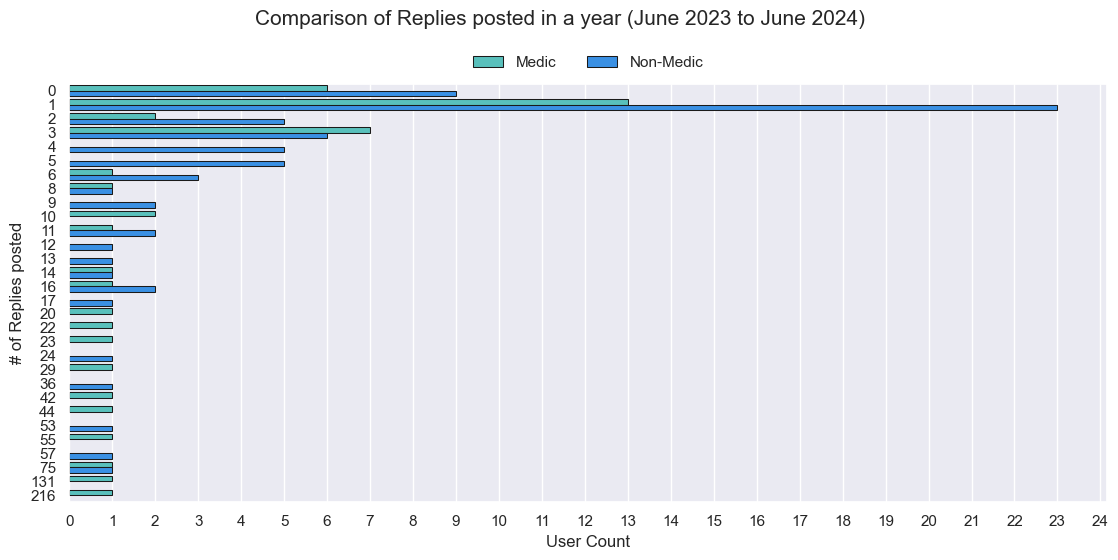

In [16]:
plotting_org_compare(merged_user_html_df, 'Replies posted', 'User Count', '# of Replies posted', hue='organization', title='Comparison of Replies posted in a year (June 2023 to June 2024)')

# Top 10 users from June 2023 to June 2024

## Yearly top users based on _Topics Created_

In [17]:
merged_user_html_df['Topics created'] = pd.to_numeric(merged_user_html_df['Topics created'])
merged_user_html_df['Replies posted'] = pd.to_numeric(merged_user_html_df['Replies posted'])

In [18]:
merged_user_html_df.nlargest(10, 'Topics created').drop(columns=['organization','Name'])

,Username,Topics created,Replies posted,Days Visited,Solutions
6,Anro,30,53,172,1
26,antony,18,10,297,2
3,Marcelo_De_Guzman,15,75,83,1
5,michael,15,55,195,1
4,cliff,13,57,123,1
17,niraj,12,16,240,2
11,bamatic,10,24,76,0
10,Esther_Moturi,9,29,143,1
9,Job_Isabai,8,36,152,0
35,Sandip_Parajuli,8,6,32,2


In [19]:
merged_user_html_df.nlargest(10, 'Replies posted').drop(columns=['organization','Name'])

,Username,Topics created,Replies posted,Days Visited,Solutions
0,diana,6,216,159,26
1,jkuester,5,131,181,18
2,mrjones,5,75,168,6
3,Marcelo_De_Guzman,15,75,83,1
4,cliff,13,57,123,1
5,michael,15,55,195,1
6,Anro,30,53,172,1
7,binod,4,44,160,9
8,gareth,6,42,126,3
9,Job_Isabai,8,36,152,0


Are Non-Medic helping answer questions or posting their own questions? Similarly,are Medic asking questions or replying to help.

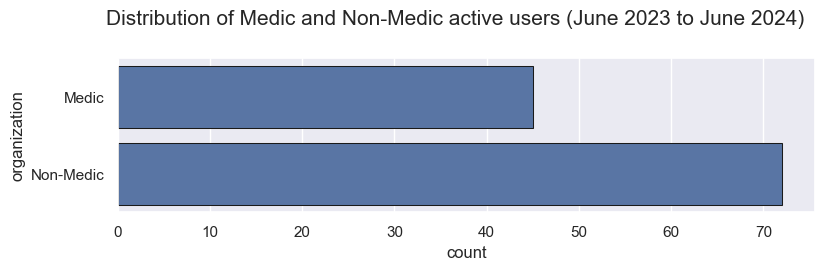

In [20]:
sns.set_theme(rc={'figure.figsize':(9,2)})
sns.countplot(data=merged_user_html_df, y='organization', linewidth=0.75, edgecolor="k");
plt.figtext(0.5, 1.05, 'Distribution of Medic and Non-Medic active users (June 2023 to June 2024)', wrap=True, horizontalalignment='center', fontsize=15);

# Signups and Contributions

For this data used were from Jan 2023 to May 2024

Two things we ask: 
1. How many new signups are happening every month?
2. How many new contributors in the forum do we have monthly?

In [21]:
df_signups = pd.read_csv('data/signups-240516-134217.csv')
df_new_contrb = pd.read_csv('data/new-contributors-240516-134113.csv')

In [22]:
df_signups['Day'] = pd.to_datetime(df_signups['Day'])
df_new_contrb['Day'] = pd.to_datetime(df_new_contrb['Day'])

In [23]:
def relationship_plt(df1, df2, col1_str, col2_str, palette=None, title=None):
    tmp_df = (pd.merge(df1, df2, on='Day', how='outer')
            .fillna(0)
            .sort_values('Day')
            .set_index('Day'))
    tmp_df.columns = [col1_str, col2_str]
    plt1_df = tmp_df.groupby(pd.Grouper(freq='M')).sum().reset_index()  # update for v0.21+
    plt1_df.set_index('Day', inplace=True)
    plt1_df = plt1_df[[col1_str, col2_str]].stack().reset_index()
    plt1_df.columns = ['Date', 'Type', 'Count']

    if palette:
        sns.lineplot(data=plt1_df, x='Date', y='Count', hue='Type', style='Type', palette=palette, markers=True)
    else:
        sns.lineplot(data=plt1_df, x='Date', y='Count', hue='Type', style='Type', markers=True)

    if title:
        plt.figtext(0.5, 1.0, title, wrap=True, horizontalalignment='center', fontsize=15)
    plt.show()

In [24]:
sns.set_theme(rc={'figure.figsize':(15,5)})

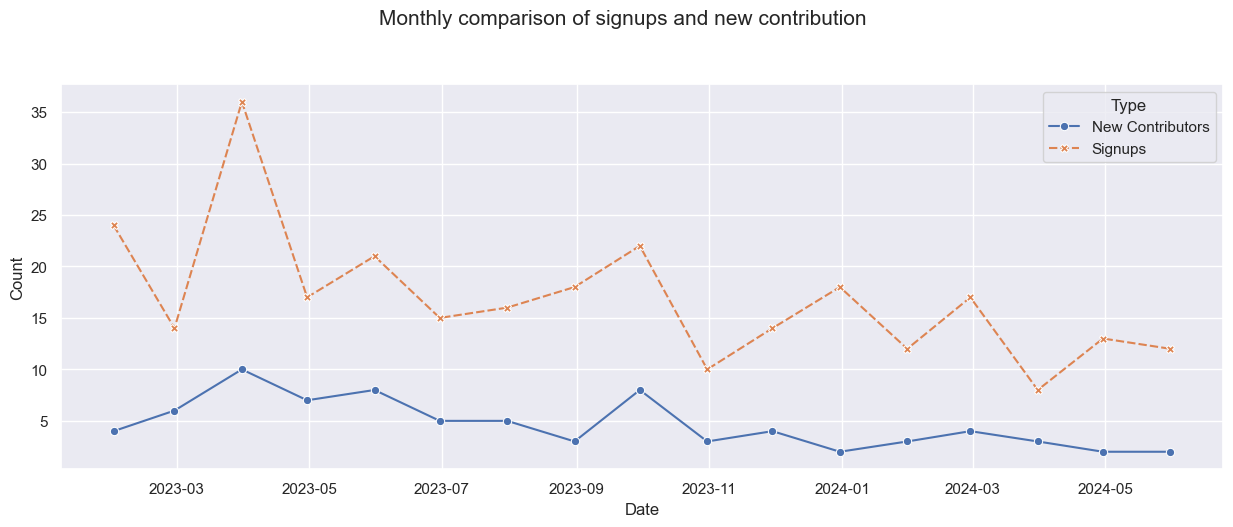

In [25]:
relationship_plt(df_new_contrb, df_signups, 'New Contributors', 'Signups', title='Monthly comparison of signups and new contribution')

# User visits from mobile vs desktop

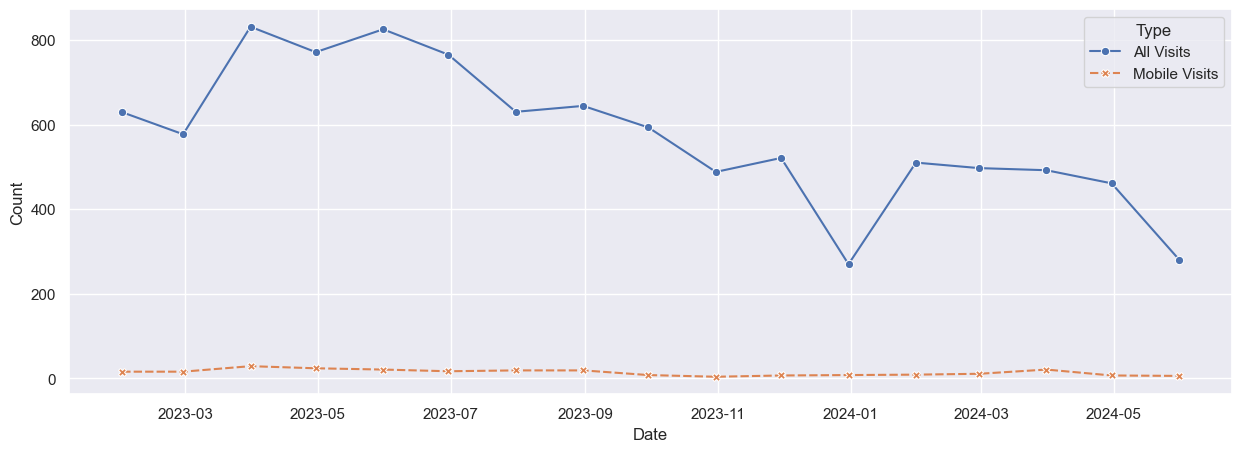

In [26]:
df_mobile_visits = pd.read_csv('data/mobile-visits-240517-073725.csv')
df_visits = pd.read_csv('data/visits-240517-073750.csv')
df_mobile_visits['Day'] = pd.to_datetime(df_mobile_visits['Day'])
df_visits['Day'] = pd.to_datetime(df_visits['Day'])

relationship_plt(df_visits, df_mobile_visits, 'All Visits', 'Mobile Visits')

# Forum Categories

In [27]:
palette = sns.color_palette("husl", 8)

## Categories and topics

First let's compare how many topics are created in different categories which helps us understand:
- What is the most popular category in CHT Forum (considering topics)?

For this purpose, we take data from each sub category of a category and see distribution within sub-category of category as well as overall category comparison.

- For **Community** category, we have *calls*, *introduction*, *jobs and funding*, *local events*, and *community* as subcategory.
- For **Product** category, we have *demo*, *documentation*, *release*, *roadmaps*, *product* as subcategory
- For **Implementation** category, we have two subcategory which are *Implementation Impact and Evaluations* and *Implementation*
- For **Technical Support** category, we have *technical support & development* and *technical support* subcategory.
- For **Research** category, we have *Research article club* and *Research* subcategory
- Other categories are **Design**, **Forum Feedback and Help**, and **covid19**.

In [28]:
def read_df_from_file(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print ('Error! File Not Found', file_path)

In [29]:
def cat_relationship_plt(dfList, col_str, y_range=None, rel_palette=None, y_type=''):

    for df in dfList:
        df['Day'] = pd.to_datetime(df['Day'])

    dfs = [df.set_index('Day') for df in dfList]
    tmp_df = pd.concat(dfs, axis=1)
    tmp_df.columns = col_str
    plt1_df = tmp_df.groupby(pd.Grouper(freq='M')).sum().reset_index()  # update for v0.21+
    plt1_df.set_index('Day', inplace=True)
    idx = pd.date_range(start='2023-01-31', end='2024-05-31', freq='M')
    plt1_df.index = pd.DatetimeIndex(plt1_df.index)
    plt1_df = plt1_df.reindex(idx, fill_value=0)

    plt1_df = plt1_df[col_str].stack().reset_index()
    plt1_df.columns = ['Date', 'Type', 'Count']


    ax = sns.lineplot(
        data=plt1_df,
        x="Date", y="Count", hue="Type", style="Type",
        markers=True, dashes=True, lw=1.5, palette=rel_palette
    )
    max_y = int(max(plt1_df['Count']))+1
    if max_y>50:
        y_values = [i for i in range(0, max_y, 20)]
    elif max_y>30:
        y_values = [i for i in range(0, max_y, 5)]
    elif max_y>15:
        y_values = [i for i in range(0, max_y, 2)]
    else:
        y_values = [i for i in range(0, max_y, 1)]

    ax.set(xticks=plt1_df.Date.values)
    ax.set(yticks=y_values)
    plt.xticks(rotation=90)
    ax.set_ylabel('{} Count'.format(y_type))
    ax.set_xlabel('Month')
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
    )
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.show()


In [30]:
def combine_dfs(df_list, type_col=None):
    for df in df_list:
        df['Day'] = pd.to_datetime(df['Day'])
    tmp_df = pd.concat(df_list, axis=0)
    tmp_df.set_index('Day', inplace=True)
    tmp_df = tmp_df.groupby(pd.Grouper(freq='M')).sum().reset_index()
    if type_col:
        tmp_df['Cat_Type'] = type_col 
        tmp_df.columns = ['Day', 'Count', 'Cat_Type']
    return tmp_df

In [31]:
sns.set_style('darkgrid')
sns.set_theme(rc={'figure.figsize':(15,5)}, font_scale=1.25)

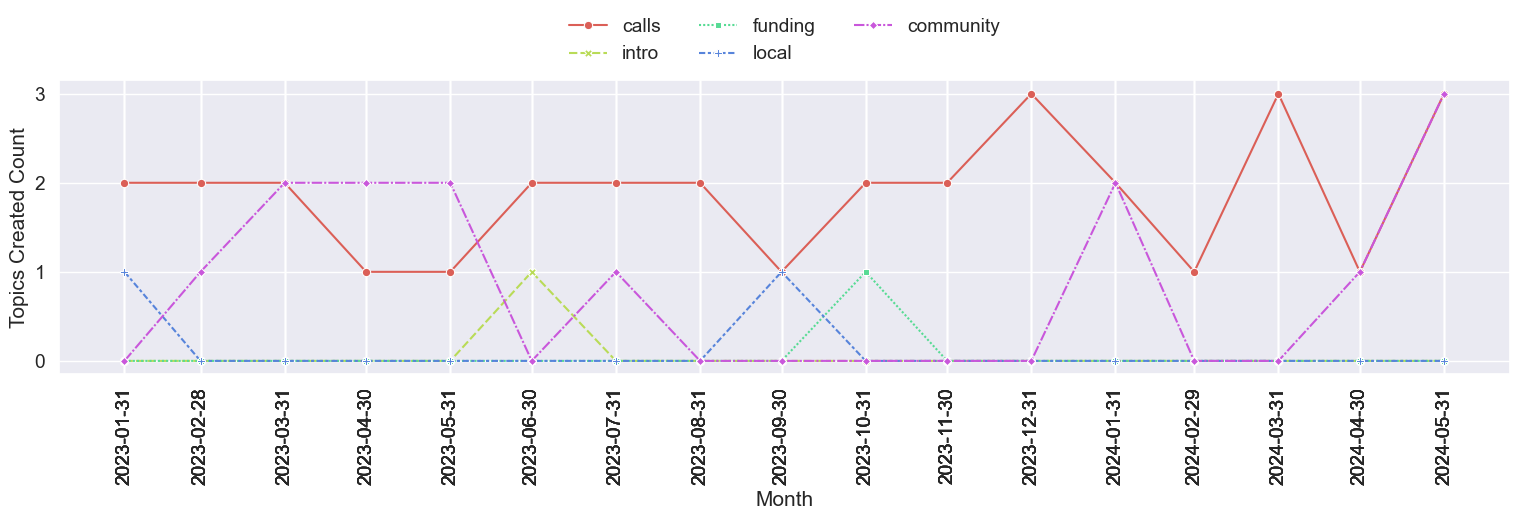

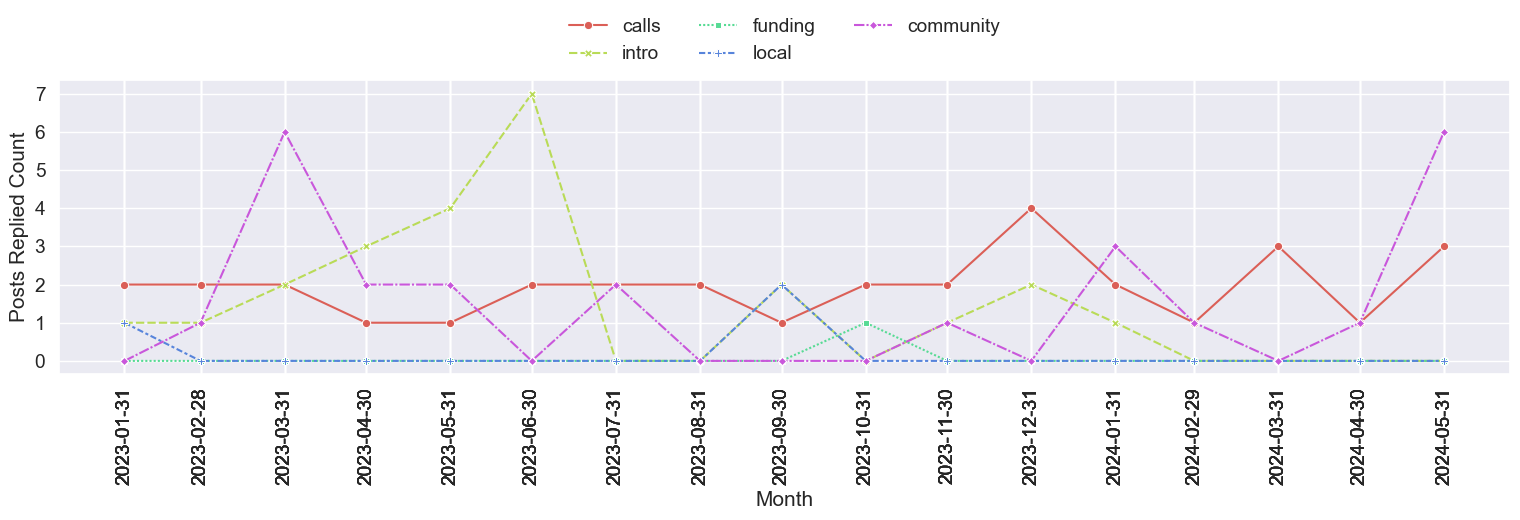

In [32]:
# read all csv files to dataframes in each directory and run functions

directory_list = ['topics', 'posts']
dfList_community_topics=None
dfList_community_posts=None

for d in directory_list:
    
    community_calls = read_df_from_file('{}/community/calls.csv'.format(d))
    community_intro = read_df_from_file('{}/community/introduction.csv'.format(d))
    community_funding = read_df_from_file('{}/community/jobs_funding.csv'.format(d))
    community_local = read_df_from_file('{}/community/local_events.csv'.format(d))
    community = read_df_from_file('{}/community/community.csv'.format(d))
    col_str_community = ['calls', 'intro', 'funding', 'local', 'community']

    if d == 'topics': 
        dfList_community_topics = [community_calls, community_intro, community_funding, community_local, community]
    elif d == 'posts':
        dfList_community_posts = [community_calls, community_intro, community_funding, community_local, community]

cat_relationship_plt(dfList_community_topics, col_str_community, rel_palette=sns.color_palette('hls', 5), y_type='Topics Created')
cat_relationship_plt(dfList_community_posts, col_str_community, rel_palette=sns.color_palette('hls', 5), y_type='Posts Replied')

Error! File Not Found posts/product/demo.csv
Error! File Not Found posts/product/roadmaps.csv


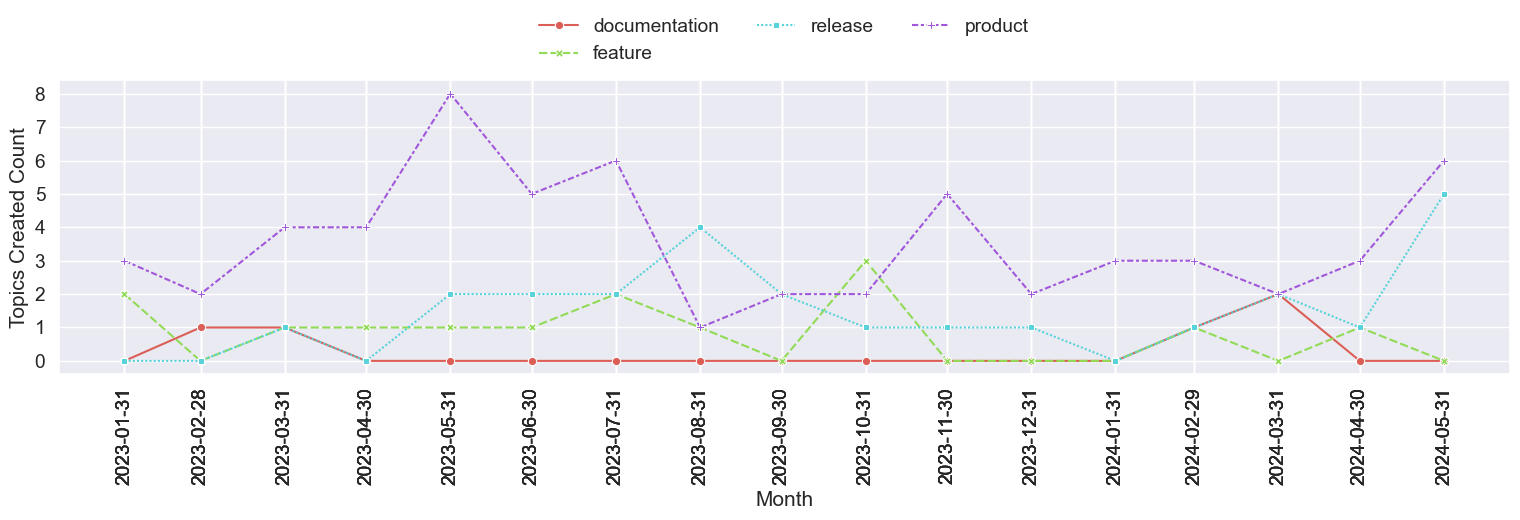

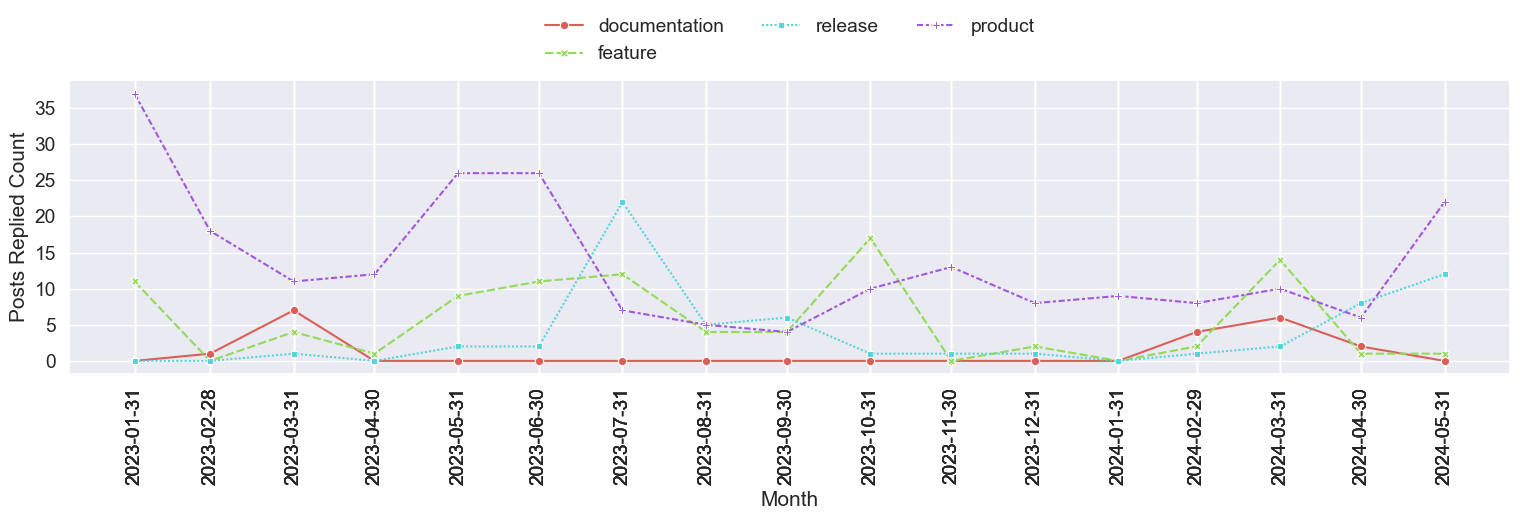

In [33]:
dfList_product_topics=None
dfList_product_posts=None

for d in directory_list:
    product_demo = read_df_from_file('{}/product/demo.csv'.format(d))
    product_documentation = read_df_from_file('{}/product/documentation.csv'.format(d))
    product_feature = read_df_from_file('{}/product/feature_request.csv'.format(d))
    product_release = read_df_from_file('{}/product/release.csv'.format(d))
    product_road_maps = read_df_from_file('{}/product/roadmaps.csv'.format(d))
    product = read_df_from_file('{}/product/product.csv'.format(d))
    col_str_product = ['documentation', 'feature', 'release', 'product']
    
    if d == 'topics': 
        dfList_product_topics = [product_documentation, product_feature, product_release, product]
    elif d == 'posts':
        dfList_product_posts = [product_documentation, product_feature, product_release, product]

cat_relationship_plt(dfList_product_topics, col_str_product, rel_palette=sns.color_palette('hls', 4), y_type='Topics Created')
cat_relationship_plt(dfList_product_posts, col_str_product, rel_palette=sns.color_palette('hls', 4), y_type='Posts Replied')

_In product category, subcategories "demo", "roadmaps" are empty tag_

_In implementation category subcategory "Implementation Impact and Evaluations" is empty tag_

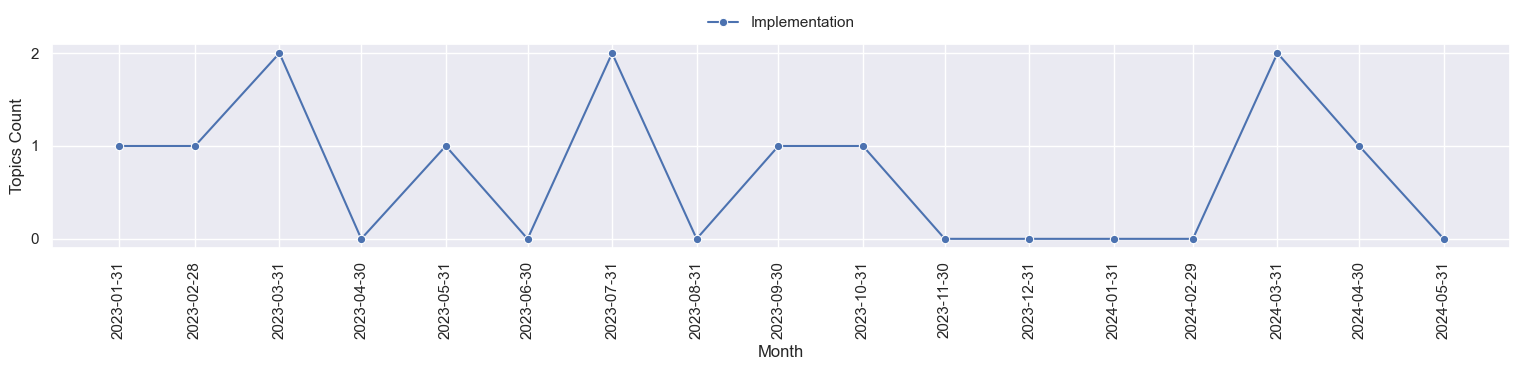

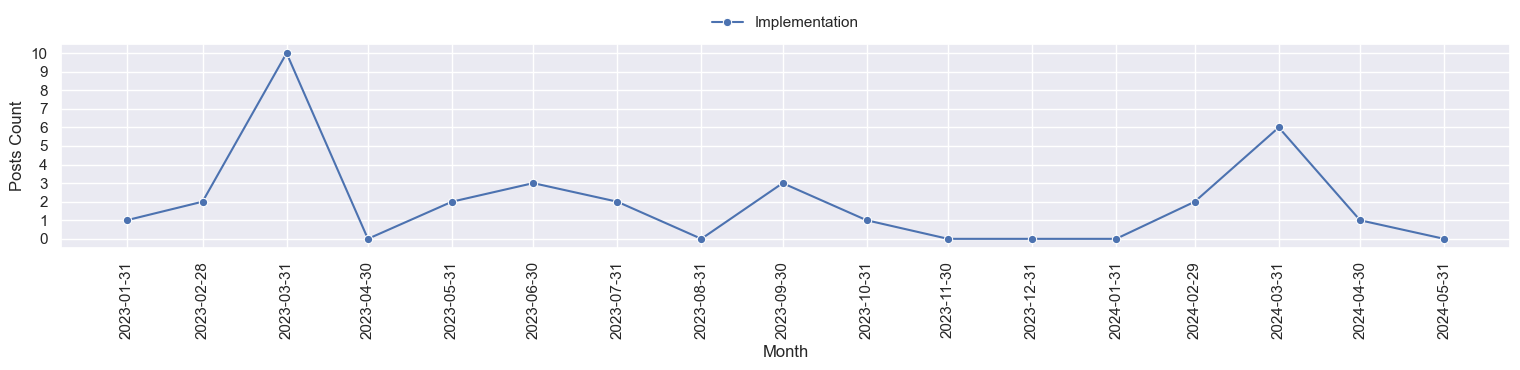

In [34]:
sns.set_theme(rc={'figure.figsize':(15,3.5)})
df_implementation_topics = None
df_implementation_posts = None

for d in directory_list:
    # ignoring Implementation_Impact_Evaluations no info there
    # implementation_impact = read_df_from_file('{}/Implementation/Implementation_Impact_Evaluations.csv'.format(d))
    implementation = read_df_from_file('{}/Implementation/implementation.csv'.format(d))
    cat_relationship_plt([implementation], ['Implementation'],  y_type='{}'.format(d.title()))
    if d == 'topics':
        df_implementation_topics = implementation
    else:
        df_implementation_posts = implementation

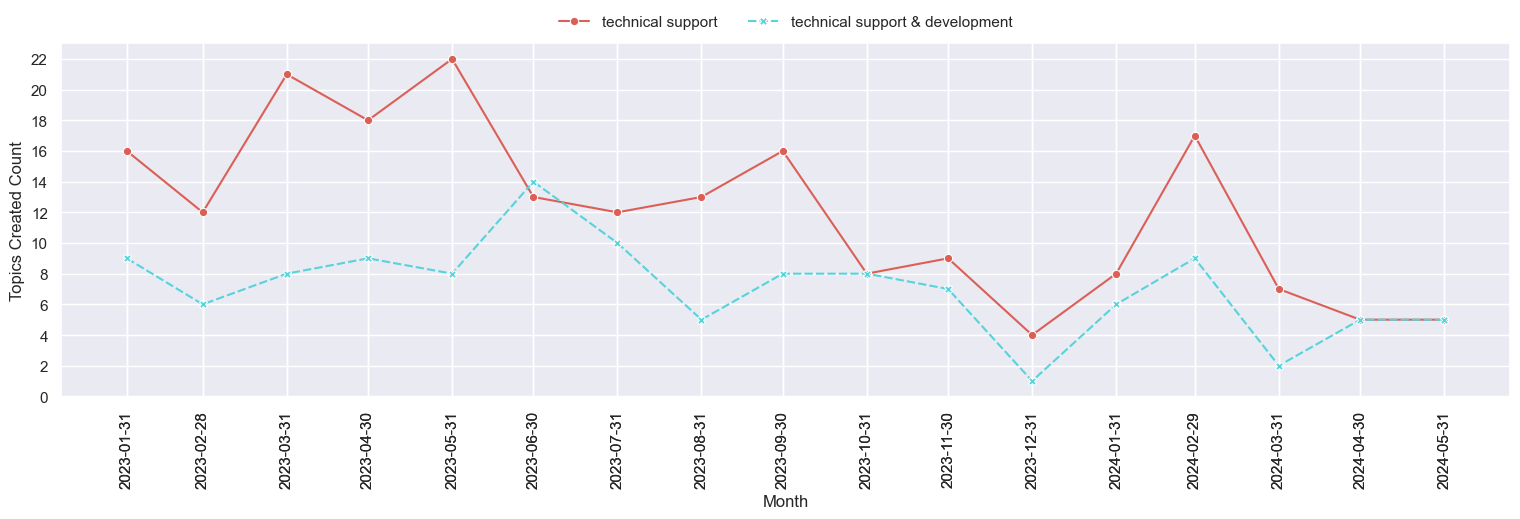

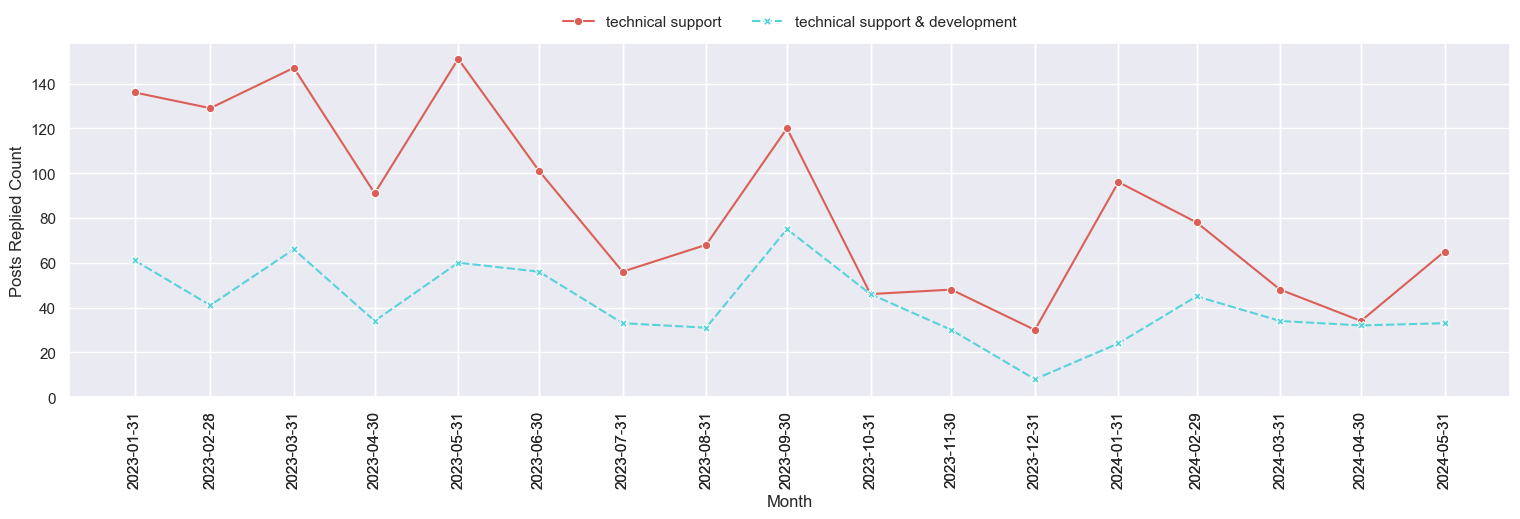

In [35]:
sns.set_theme(rc={'figure.figsize':(15,5)})

dfList_tech_spprt_topics=None
dfList_tech_spprt_posts=None

for d in directory_list:
    technical_support_development = read_df_from_file('{}/Technical/technical_support_development.csv'.format(d))
    technical_support = read_df_from_file('{}/Technical/technical_support.csv'.format(d))
    col_str_technical_support = ['technical support', 'technical support & development']
    
    if d == 'topics': 
        dfList_tech_spprt_topics = [technical_support, technical_support_development]
    elif d == 'posts':
        dfList_tech_spprt_posts = [technical_support, technical_support_development]

cat_relationship_plt(dfList_tech_spprt_topics, col_str_technical_support, rel_palette=sns.color_palette('hls', 2), y_type='Topics Created')
cat_relationship_plt(dfList_tech_spprt_posts, col_str_technical_support, rel_palette=sns.color_palette('hls', 2), y_type='Posts Replied')

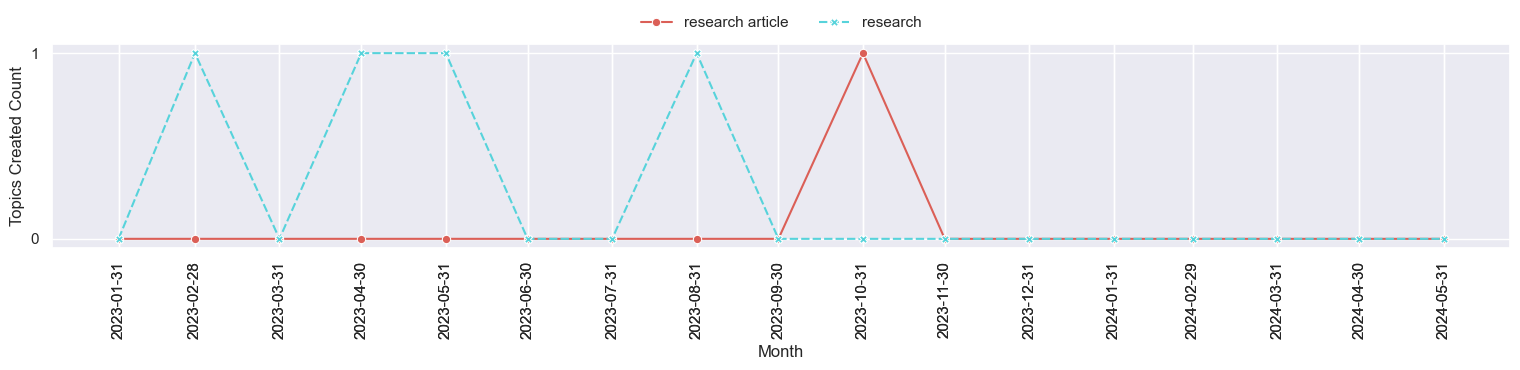

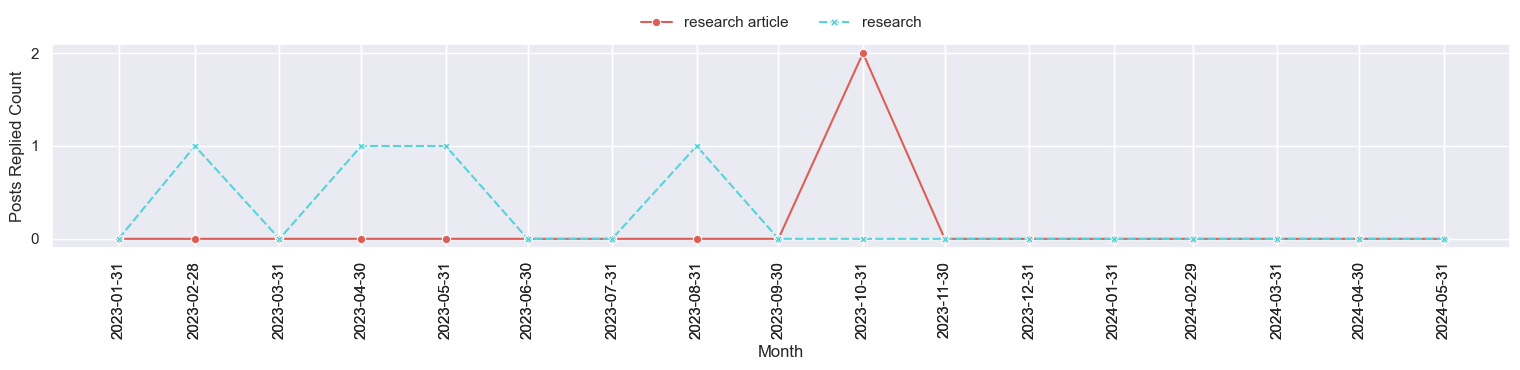

In [36]:
sns.set_theme(rc={'figure.figsize':(15,3.5)})

dfList_resrch_topics=None
dfList_resrch_posts=None

for d in directory_list:
    research_article = read_df_from_file('{}/Research/research_article.csv'.format(d))
    research = read_df_from_file('{}/Research/research.csv'.format(d))
    col_str_research = ['research article', 'research']
    
    if d == 'topics': 
        dfList_resrch_topics = [research_article, research]
    elif d == 'posts':
        dfList_resrch_posts = [research_article, research]

cat_relationship_plt(dfList_resrch_topics, col_str_research, rel_palette=sns.color_palette('hls', 2), y_type='Topics Created')
cat_relationship_plt(dfList_resrch_posts, col_str_research, rel_palette=sns.color_palette('hls', 2), y_type='Posts Replied')

_No new topics were created in category "covid19" but there were few posts_

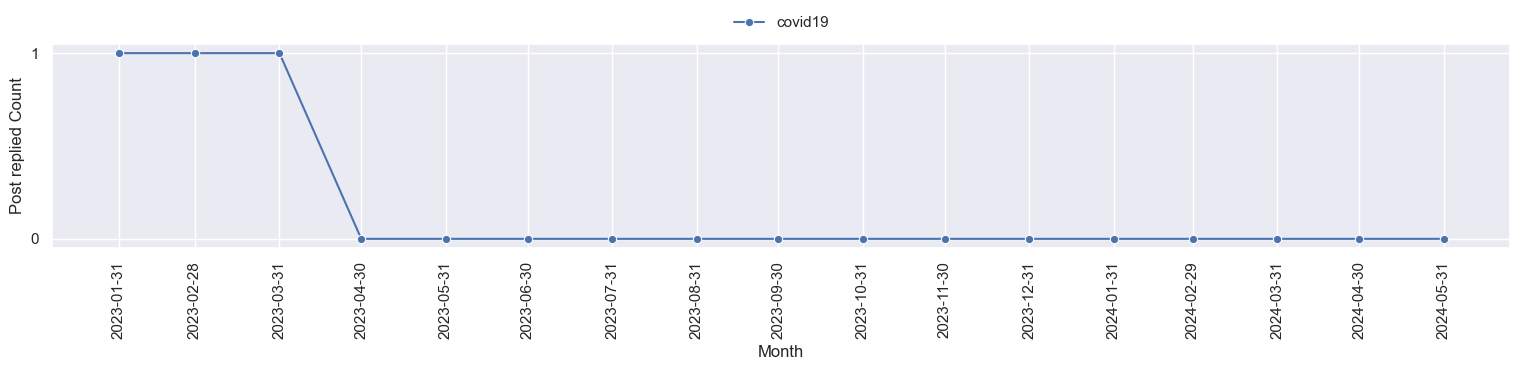

In [37]:
covid_df = read_df_from_file('posts/covid19.csv')
cat_relationship_plt([covid_df], ['covid19'],  y_type='Post replied')

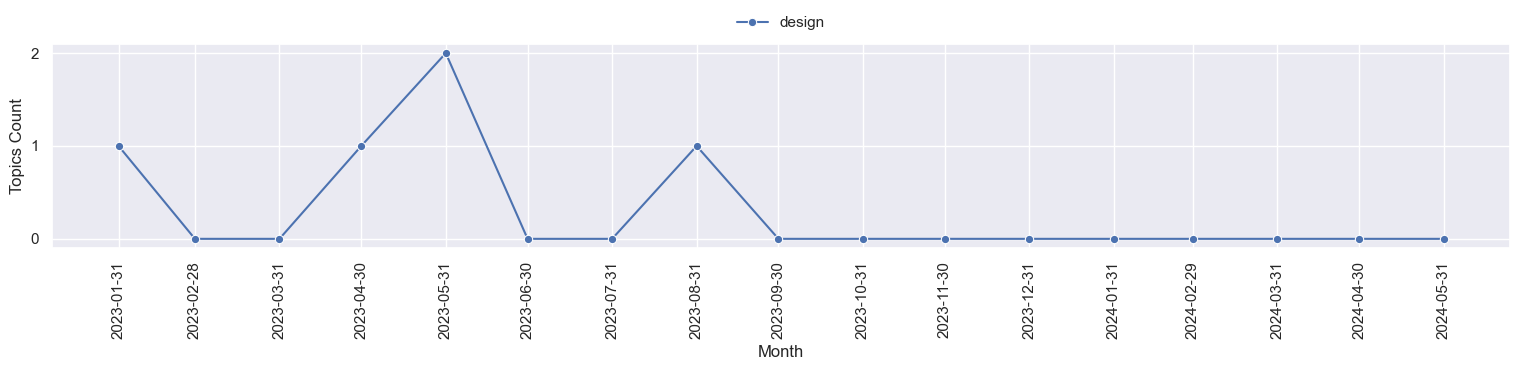

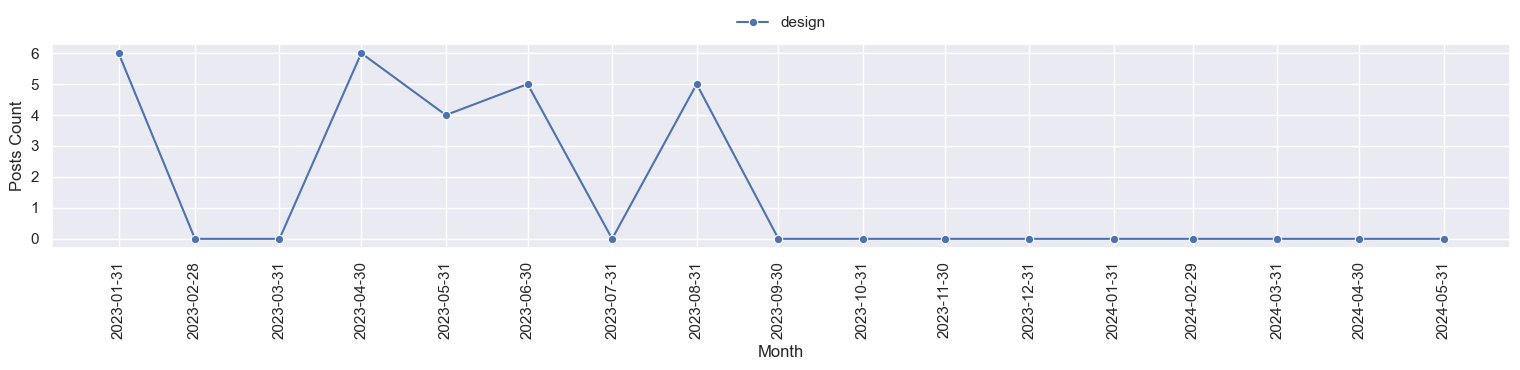

In [38]:
df_design_topics = None
df_design_posts = None

for d in directory_list:
    design_df = read_df_from_file('{}/design.csv'.format(d))
    cat_relationship_plt([design_df], ['design'],  y_type='{}'.format(d.title()))
    if d == 'topics':
        df_design_topics = design_df
    else:
        df_design_posts = design_df

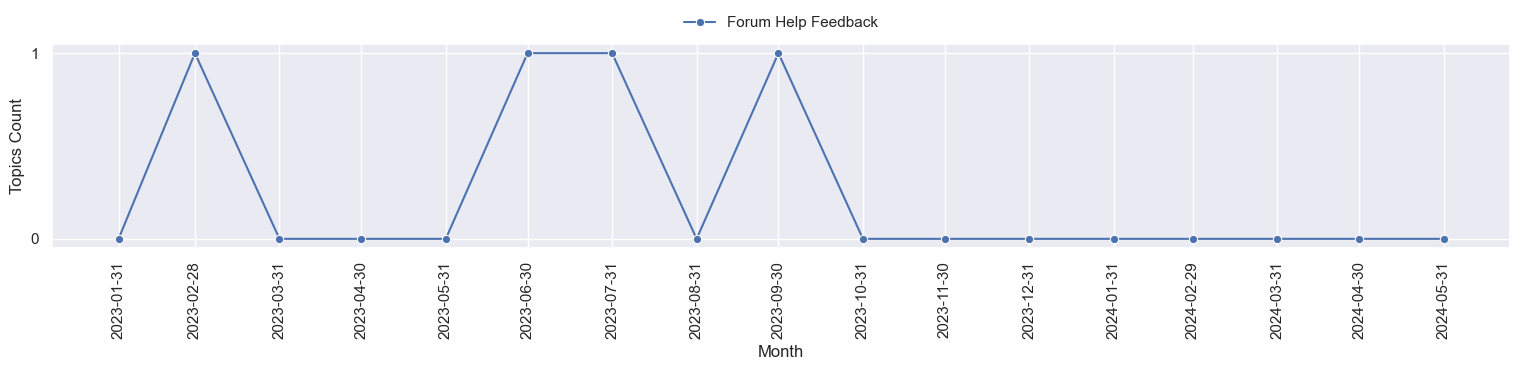

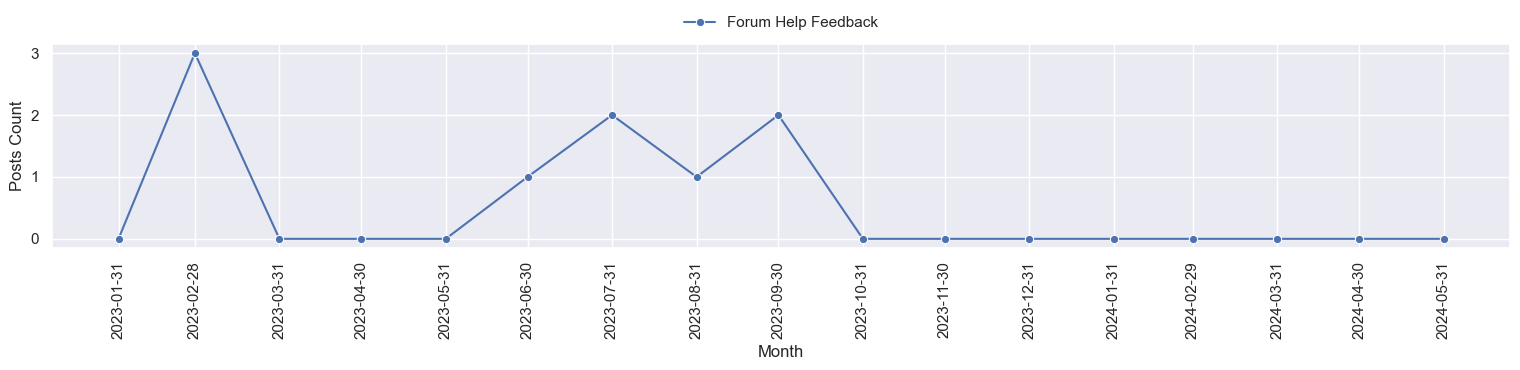

In [39]:
df_frm_feedback_topics = None
df_frm_feedback_posts = None

for d in directory_list:
    forum_feedback_df = read_df_from_file('{}/forum_help_feedback.csv'.format(d))
    cat_relationship_plt([forum_feedback_df], ['Forum Help Feedback'],  y_type='{}'.format(d.title()))
    if d == 'topics':
        df_frm_feedback_topics = forum_feedback_df
    else:
        df_frm_feedback_posts = forum_feedback_df

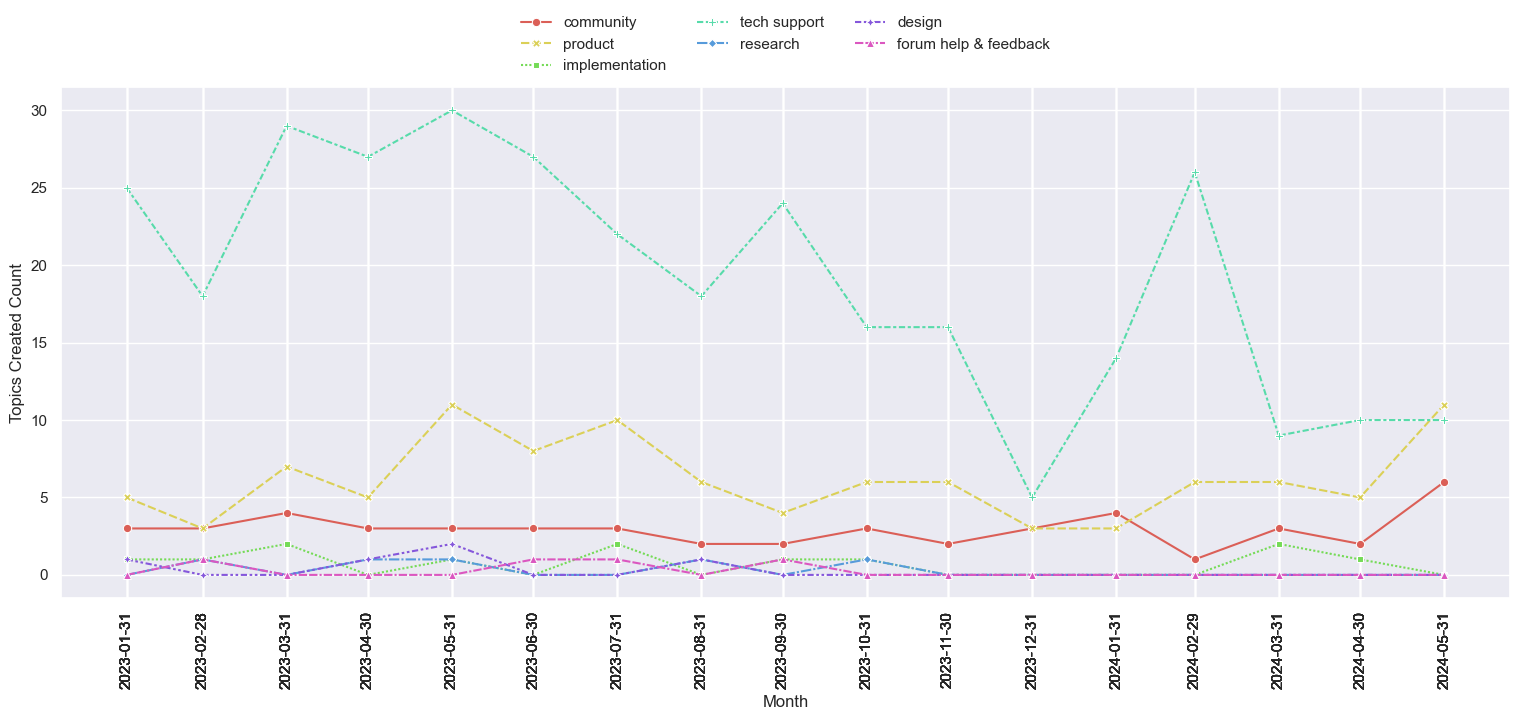

In [40]:
sns.set_theme(rc={'figure.figsize':(15, 7)})

cat_relationship_plt([combine_dfs(dfList_community_topics), 
                      combine_dfs(dfList_product_topics), 
                      df_implementation_topics, 
                      combine_dfs(dfList_tech_spprt_topics), 
                      combine_dfs(dfList_resrch_topics), 
                      df_design_topics, df_frm_feedback_topics], 
                     ['community', 'product', 'implementation', 'tech support', 'research', 'design', 'forum help & feedback'], 
                     rel_palette=sns.color_palette('hls', 7), y_type='Topics Created')

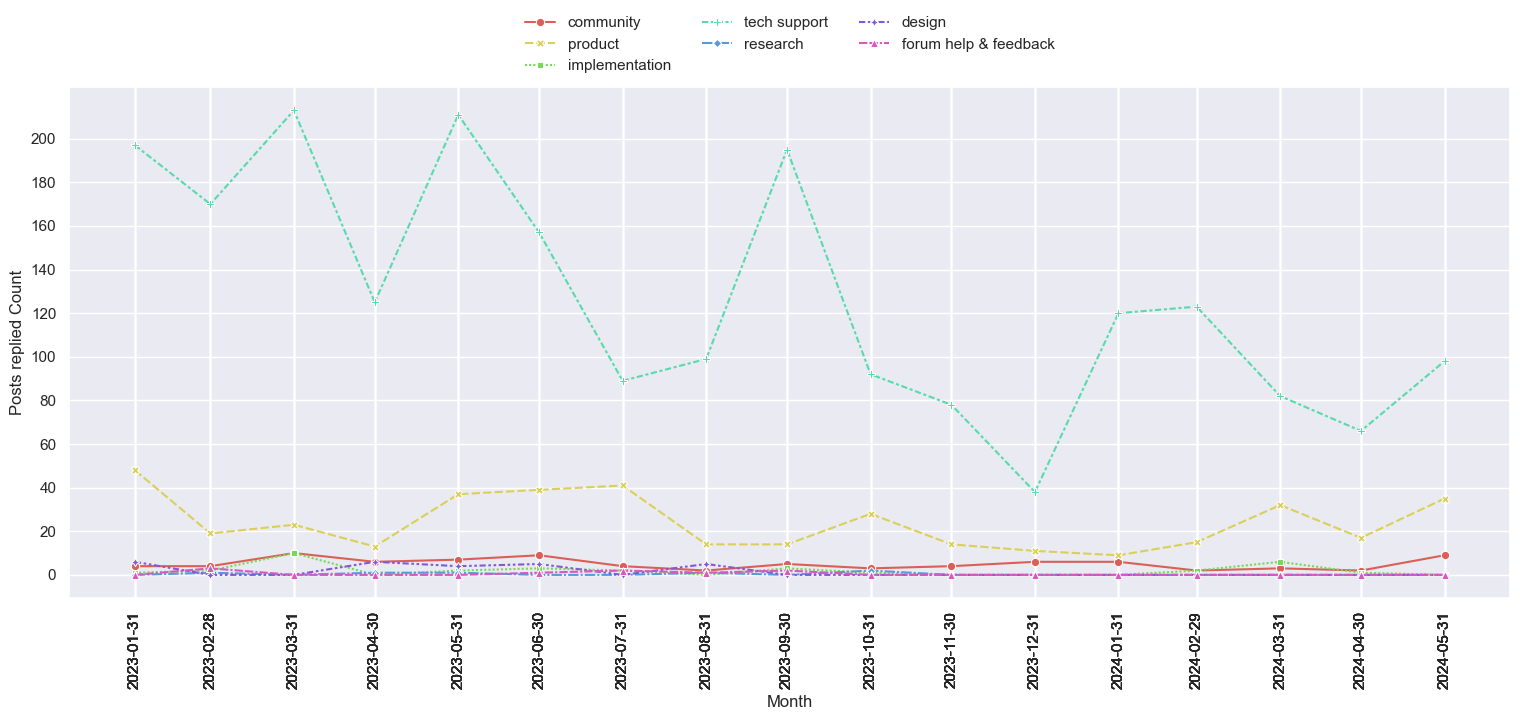

In [41]:
cat_relationship_plt([combine_dfs(dfList_community_posts), 
                      combine_dfs(dfList_product_posts), 
                      df_implementation_posts, 
                      combine_dfs(dfList_tech_spprt_posts), 
                      combine_dfs(dfList_resrch_posts), 
                      df_design_posts, df_frm_feedback_posts], 
                     ['community', 'product', 'implementation', 'tech support', 'research', 'design', 'forum help & feedback'], 
                     rel_palette=sns.color_palette('hls', 7), y_type='Posts replied')

The documentation improvement and addition are not posted in CHT Forum. Some of them are misinterpreted. For example [this](https://forum.communityhealthtoolkit.org/t/count-total-docs-in-cht/2536) one here uses this tag of documentation on different contexts. Other is benchmarking of two different version. It needs clarity on when to use documentation.

Design category is inactive since August 2023. Are we using Product category instead? We see design under product category, also other frequently used one is ui-ux.

In [42]:
topics_combined_df = pd.concat([combine_dfs(dfList_community_topics, 'community'), 
                      combine_dfs(dfList_product_topics, 'product'), 
                      combine_dfs([df_implementation_topics], 'implementation'), 
                      combine_dfs(dfList_tech_spprt_topics, 'tech support'), 
                      combine_dfs(dfList_resrch_topics, 'research'), 
                      combine_dfs([df_design_topics],'design'), 
                      combine_dfs([df_frm_feedback_topics],'forum feedback')],
           )
topics_cat_sum = topics_combined_df.groupby('Cat_Type')['Count'].sum().reset_index()
topics_cat_sum.columns = ['Category', 'Topics Sum']

In [43]:
posts_combined_df = pd.concat([combine_dfs(dfList_community_posts, 'community'), 
                      combine_dfs(dfList_product_posts, 'product'), 
                      combine_dfs([df_implementation_posts], 'implementation'), 
                      combine_dfs(dfList_tech_spprt_posts, 'tech support'), 
                      combine_dfs(dfList_resrch_posts, 'research'), 
                      combine_dfs([df_design_posts],'design'), 
                      combine_dfs([df_frm_feedback_posts],'forum feedback')],
           )
posts_cat_sum = posts_combined_df.groupby('Cat_Type')['Count'].sum().reset_index()
posts_cat_sum.columns = ['Category', 'Posts Sum']

In [44]:
topics_cat_sum.merge(posts_cat_sum, how='left', on='Category')

,Category,Topics Sum,Posts Sum
0,community,50,86
1,design,5,26
2,forum feedback,4,9
3,implementation,12,33
4,product,105,409
5,research,5,6
6,tech support,326,2153


It is interesting to see some interaction in "forum feedback" but if you look into actual conversations, majority are technical issues and one survey request.